DAG edges:
  TrafficLevel -> AQI
  IndustrialActivity -> AQI
  Temperature -> AQI
  Humidity -> AQI
  AQI -> RespiratoryCases



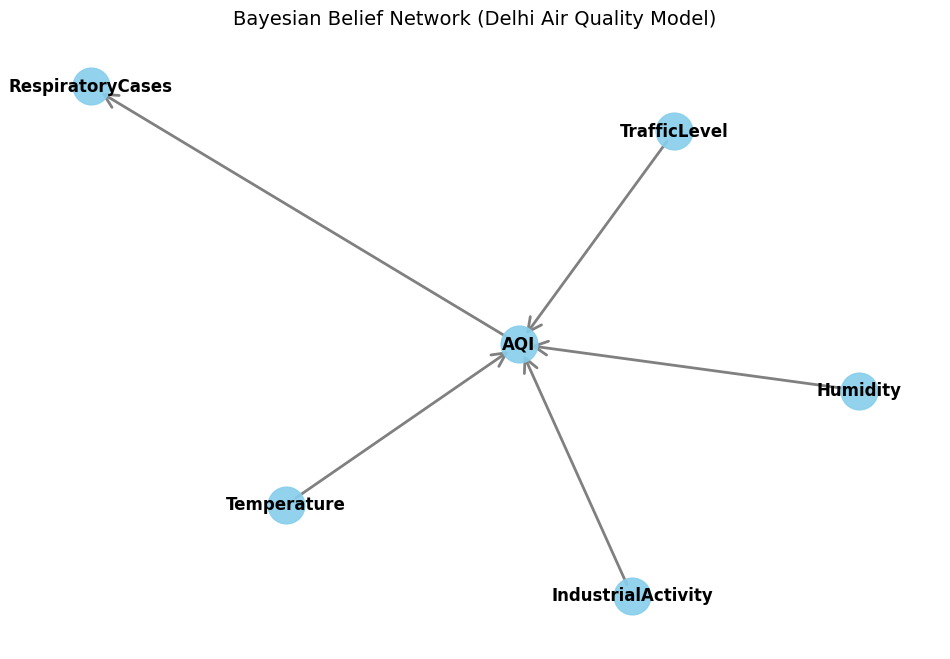

In [1]:
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict, Counter
from IPython.display import display
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(42)

# -------------------------
# 1) Define variables/states and DAG
# -------------------------
vars_states = {
    'TrafficLevel': ['low','medium','high'],
    'IndustrialActivity': ['low','medium','high'],
    'Temperature': ['cold','mild','hot'],
    'Humidity': ['low','medium','high'],
    'AQI': ['good','moderate','poor'],
    'RespiratoryCases': ['low','medium','high']
}

# Parents mapping (DAG edges)
parents = {
    'TrafficLevel': [],  # Exogenous variable: traffic volume is not caused by other variables in this simplified model.

    'IndustrialActivity': [],  # Exogenous variable: industry output level is determined independently of weather or AQI here.

    'Temperature': [],  # Weather variable treated as exogenous; not influenced by pollution or health outcomes.

    'Humidity': [],  # Also an exogenous weather factor unaffected by other variables in this DAG.

    'AQI': ['TrafficLevel', 'IndustrialActivity', 'Temperature', 'Humidity'],
    # TrafficLevel → AQI: More vehicles release pollutants, raising AQI.
    # IndustrialActivity → AQI: Factories emit particulate matter and gases, worsening AQI.
    # Temperature → AQI: Higher temperatures can increase ozone formation and pollution concentration.
    # Humidity → AQI: Humidity affects particulate suspension and dispersion, impacting AQI levels.

    'RespiratoryCases': ['AQI']
    # AQI → RespiratoryCases: Poor air quality increases respiratory illnesses such as asthma or bronchitis.
}

print("DAG edges:")
edges = []
for child, ps in parents.items():
    for p in ps:
        edges.append((p, child))
        print(f"  {p} -> {child}")
print()

# -------------------------
# Draw DAG using NetworkX
# -------------------------
plt.figure(figsize=(12,8))
G = nx.DiGraph()
G.add_edges_from(edges)

# Layout options: spring_layout or shell_layout or hierarchy via graphviz_layout if available
pos = nx.spring_layout(G, seed=42)  # You can also try nx.shell_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=700, alpha=0.9)
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=25, edge_color="gray", width=2)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title("Bayesian Belief Network (Delhi Air Quality Model)", fontsize=14)
plt.axis("off")
plt.show()

In [2]:
# -------------------------
# 2) Ground-truth CPTs (for sampling)
# -------------------------
# Root priors (plausible)
P_Traffic = np.array([0.3, 0.5, 0.2])        # low, medium, high
P_Industrial = np.array([0.2, 0.6, 0.2])
P_Temperature = np.array([0.25, 0.5, 0.25])
P_Humidity = np.array([0.4, 0.4, 0.2])

# Generate AQI probabilities from parent states
def aqi_probs_from_parents(traf, ind, temp, hum):
    # Score "badness" from parents; higher => worse AQI
    score = 0.0
    score += {'low':0.0,'medium':0.5,'high':1.0}[traf]
    score += {'low':0.0,'medium':0.5,'high':1.0}[ind]
    score += {'cold':0.0,'mild':0.2,'hot':0.6}[temp]
    score += {'low':0.5,'medium':0.2,'high':0.0}[hum]
    # Convert to logits for (good, moderate, poor)
    logits = np.array([-1.5*score, -0.3*score, 1.2*score]) + np.array([1.0, 0.5, 0.2])
    exp = np.exp(logits - np.max(logits))
    probs = exp / exp.sum()
    return probs

# RespiratoryCases | AQI (plausible mapping)
P_Resp_given_AQI = {
    'good':     np.array([0.8, 0.15, 0.05]),   # low, medium, high
    'moderate': np.array([0.3, 0.5, 0.2]),
    'poor':     np.array([0.05, 0.25, 0.7])
}

In [4]:
def sample_one():
    traf = np.random.choice(vars_states['TrafficLevel'], p=P_Traffic)
    ind = np.random.choice(vars_states['IndustrialActivity'], p=P_Industrial)
    temp = np.random.choice(vars_states['Temperature'], p=P_Temperature)
    hum = np.random.choice(vars_states['Humidity'], p=P_Humidity)
    aqi_p = aqi_probs_from_parents(traf, ind, temp, hum)
    aqi = np.random.choice(vars_states['AQI'], p=aqi_p)
    resp_p = P_Resp_given_AQI[aqi]
    resp = np.random.choice(vars_states['RespiratoryCases'], p=resp_p)
    return {'TrafficLevel': traf, 'IndustrialActivity': ind,
            'Temperature': temp, 'Humidity': hum,
            'AQI': aqi, 'RespiratoryCases': resp}

n = 1000         # dataset size
data = [sample_one() for _ in range(n)]
df = pd.DataFrame(data)
print("\nSample of generated dataset:")
display(df.head())

# Save CSV
csv_path = 'content/synthetic_delhi_aqi_dataset.csv'
df.to_csv(csv_path, index=False)
print(f"\nSaved synthetic dataset to: {csv_path}")



Sample of generated dataset:


,TrafficLevel,IndustrialActivity,Temperature,Humidity,AQI,RespiratoryCases
0,medium,low,hot,medium,moderate,high
1,medium,low,mild,low,poor,high
2,high,medium,mild,medium,poor,high
3,medium,low,mild,high,poor,medium
4,low,medium,hot,low,poor,medium



Saved synthetic dataset to: content/synthetic_delhi_aqi_dataset.csv


In [5]:
# -------------------------
# 4) Estimate CPTs from data (frequency + Dirichlet smoothing)
# -------------------------
alpha = 1.0  # Dirichlet pseudocount per child state

def estimate_cpt(df, node, parents_list):
    states = vars_states[node]
    if not parents_list:
        counts = df[node].value_counts().reindex(states, fill_value=0).values.astype(float)
        counts += alpha
        probs = counts / counts.sum()
        return {(): probs}
    else:
        cpt = {}
        parent_states_lists = [vars_states[p] for p in parents_list]
        for parent_combo in itertools.product(*parent_states_lists):
            mask = np.ones(len(df), dtype=bool)
            for p, val in zip(parents_list, parent_combo):
                mask &= (df[p] == val)
            sub = df[mask]
            counts = sub[node].value_counts().reindex(states, fill_value=0).values.astype(float)
            counts += alpha
            probs = counts / counts.sum() if counts.sum() > 0 else np.ones(len(states)) / len(states)
            cpt[parent_combo] = probs
        return cpt

estimated_cpts = {}
for node in vars_states:
    estimated_cpts[node] = estimate_cpt(df, node, parents[node])

# Helper to print CPT as DataFrame
def cpt_to_df(cpt, node, parents_list):
    rows = []
    if not parents_list:
        probs = cpt[()]
        for val, p in zip(vars_states[node], probs):
            rows.append({**{pname: None for pname in parents_list}, 'child': node, 'child_state': val, 'prob': p})
    else:
        for parent_combo, probs in cpt.items():
            base = {pname: val for pname, val in zip(parents_list, parent_combo)}
            for val, p in zip(vars_states[node], probs):
                row = dict(base)
                row.update({'child': node, 'child_state': val, 'prob': p})
                rows.append(row)
    return pd.DataFrame(rows)

print("\nEstimated CPT for RespiratoryCases | AQI:")
display(cpt_to_df(estimated_cpts['RespiratoryCases'], 'RespiratoryCases', parents['RespiratoryCases']))

# Print a few AQI conditional rows
print("\nExample estimated P(AQI | parents) for a few parent combos:")
aqi_cpt_df = cpt_to_df(estimated_cpts['AQI'], 'AQI', parents['AQI'])
display(aqi_cpt_df.head(12))


Estimated CPT for RespiratoryCases | AQI:


,AQI,child,child_state,prob
0,good,RespiratoryCases,low,0.703125
1,good,RespiratoryCases,medium,0.203125
2,good,RespiratoryCases,high,0.093750
3,moderate,RespiratoryCases,low,0.286713
4,moderate,RespiratoryCases,medium,0.461538
5,moderate,RespiratoryCases,high,0.251748
6,poor,RespiratoryCases,low,0.064838
7,poor,RespiratoryCases,medium,0.254364
8,poor,RespiratoryCases,high,0.680798



Example estimated P(AQI | parents) for a few parent combos:


,TrafficLevel,IndustrialActivity,Temperature,Humidity,child,child_state,prob
0,low,low,cold,low,AQI,good,0.300000
1,low,low,cold,low,AQI,moderate,0.300000
2,low,low,cold,low,AQI,poor,0.400000
3,low,low,cold,medium,AQI,good,0.416667
4,low,low,cold,medium,AQI,moderate,0.250000
5,low,low,cold,medium,AQI,poor,0.333333
6,low,low,cold,high,AQI,good,0.111111
7,low,low,cold,high,AQI,moderate,0.444444
8,low,low,cold,high,AQI,poor,0.444444
9,low,low,mild,low,AQI,good,0.200000


In [6]:
# -------------------------
# 5) Exact inference by enumeration (supports interventions via do)
# -------------------------
all_vars = list(vars_states.keys())

def prob_from_cpt(var, val, assignment, cpts):
    states = vars_states[var]
    idx = states.index(val)
    pars = parents[var]
    if not pars:
        probs = cpts[var][()]
        return probs[idx]
    key = tuple(assignment[p] for p in pars)
    probs = cpts[var][key]
    return probs[idx]

def enumeration_query(query, evidence, cpts, do_intervene=None):
    """
    query: dict var->state (one or multiple)
    evidence: dict var->state
    do_intervene: dict var->state to intervene on (do-operator)
    returns P(query | evidence) (or under intervention if do_intervene provided)
    """
    do_intervene = do_intervene or {}
    numerator = 0.0
    denominator = 0.0
    # iterate all full assignments (product of states)
    states_lists = [vars_states[v] for v in all_vars]
    for prod in itertools.product(*states_lists):
        assign = dict(zip(all_vars, prod))
        if not all(assign[v] == s for v, s in evidence.items()):
            continue  # only consider assignments consistent with evidence
        # joint probability under model with interventions
        p = 1.0
        for v in all_vars:
            val = assign[v]
            if v in do_intervene:
                # under do(v = value): v must be that value; incoming edges are cut
                if val != do_intervene[v]:
                    p = 0.0
                    break
                else:
                    continue  # factor 1 for the forced node
            # otherwise use estimated CPT
            p *= prob_from_cpt(v, val, assign, cpts)
            if p == 0.0:
                break
        if p == 0.0:
            continue
        denominator += p
        if all(assign[v] == s for v, s in query.items()):
            numerator += p
    if denominator == 0.0:
        return 0.0
    return numerator / denominator

In [7]:
# -------------------------
# 6) Requested inference queries
# -------------------------
print("\n--- Inference Results (using estimated CPTs learned from synthetic data) ---\n")

q1 = {'AQI': 'good'}
e1 = {'TrafficLevel': 'low'}
p1 = enumeration_query(q1, e1, estimated_cpts)
print(f"P(AQI = good | TrafficLevel = low) = {p1:.4f}")

q2 = {'RespiratoryCases': 'low'}
e2 = {'AQI': 'good'}
p2 = enumeration_query(q2, e2, estimated_cpts)
print(f"P(RespiratoryCases = low | AQI = good) = {p2:.4f}")

# Two non-trivial extra queries:
q3 = {'AQI': 'poor'}
e3 = {'IndustrialActivity': 'high', 'Temperature': 'hot'}
p3 = enumeration_query(q3, e3, estimated_cpts)
print(f"P(AQI = poor | IndustrialActivity = high, Temperature = hot) = {p3:.4f}")

q4 = {'RespiratoryCases': 'low'}
e4 = {'TrafficLevel': 'low', 'IndustrialActivity': 'low'}
p4 = enumeration_query(q4, e4, estimated_cpts)
print(f"P(RespiratoryCases = low | TrafficLevel = low, IndustrialActivity = low) = {p4:.4f}")



--- Inference Results (using estimated CPTs learned from synthetic data) ---

P(AQI = good | TrafficLevel = low) = 0.1683
P(RespiratoryCases = low | AQI = good) = 0.7031
P(AQI = poor | IndustrialActivity = high, Temperature = hot) = 0.7436
P(RespiratoryCases = low | TrafficLevel = low, IndustrialActivity = low) = 0.2942


In [8]:
# -------------------------
# 7) Intervention analysis (do-operator)
# -------------------------
# Observational probability:
obs = enumeration_query({'RespiratoryCases': 'low'}, {'TrafficLevel': 'low'}, estimated_cpts)
# Interventional probability: do(TrafficLevel = low)
interv = enumeration_query({'RespiratoryCases': 'low'}, {}, estimated_cpts, do_intervene={'TrafficLevel': 'low'})

print("\n--- Intervention Analysis ---\n")
print(f"Observational P(RespiratoryCases=low | TrafficLevel=low) = {obs:.4f}")
print(f"Interventional P(RespiratoryCases=low | do(TrafficLevel=low)) = {interv:.4f}")
print("\nNote: observational conditioning keeps natural correlations (Traffic may correlate with IndustrialActivity etc.).\n"
      "The do-operator severs incoming edges to the intervened node, modeling an external policy that forces Traffic to low.\n")


--- Intervention Analysis ---

Observational P(RespiratoryCases=low | TrafficLevel=low) = 0.2256
Interventional P(RespiratoryCases=low | do(TrafficLevel=low)) = 0.2256

Note: observational conditioning keeps natural correlations (Traffic may correlate with IndustrialActivity etc.).
The do-operator severs incoming edges to the intervened node, modeling an external policy that forces Traffic to low.



In [10]:
# -------------------------
# 8) Additional outputs for report: CPT tables saved and displayed
# -------------------------
# Save learned CPTs as CSVs for reporting
def save_cpt_csv(cpt, node, parents_list, folder='/content'):
    df_cpt = cpt_to_df(cpt, node, parents_list)
    fname = f"{folder}/CPT_{node}.csv"
    df_cpt.to_csv(fname, index=False)
    return fname

saved_files = []
for node in vars_states:
    f = save_cpt_csv(estimated_cpts[node], node, parents[node], folder='content')
    saved_files.append(f)

print("\nSaved learned CPT CSVs to /content (one per node).")
print("Files:", saved_files)

# Display a couple of CPTs for quick inspection
print("\nPriors for root variables (learned from data):")
for root in ['TrafficLevel','IndustrialActivity','Temperature','Humidity']:
    print(f"\nEstimated P({root}):")
    display(cpt_to_df(estimated_cpts[root], root, parents[root]))

print("\nDone. You can download the CSVs from the Colab file browser (left pane) or via the paths printed above.")


Saved learned CPT CSVs to /content (one per node).
Files: ['content/CPT_TrafficLevel.csv', 'content/CPT_IndustrialActivity.csv', 'content/CPT_Temperature.csv', 'content/CPT_Humidity.csv', 'content/CPT_AQI.csv', 'content/CPT_RespiratoryCases.csv']

Priors for root variables (learned from data):

Estimated P(TrafficLevel):


,child,child_state,prob
0,TrafficLevel,low,0.292124
1,TrafficLevel,medium,0.501496
2,TrafficLevel,high,0.206381



Estimated P(IndustrialActivity):


,child,child_state,prob
0,IndustrialActivity,low,0.220339
1,IndustrialActivity,medium,0.596211
2,IndustrialActivity,high,0.183450



Estimated P(Temperature):


,child,child_state,prob
0,Temperature,cold,0.257228
1,Temperature,mild,0.505484
2,Temperature,hot,0.237288



Estimated P(Humidity):


,child,child_state,prob
0,Humidity,low,0.402792
1,Humidity,medium,0.399801
2,Humidity,high,0.197408



Done. You can download the CSVs from the Colab file browser (left pane) or via the paths printed above.
